In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
def global_depth(rank):
    """
    will return the first power of 8 greater than rank, the power corresponding to the level
    """
    level = 1
    loop = True

    while loop:

        if rank <= 8**level:
            loop = False
            result = level
        else:
            level += 1
    
    return result

v_global_depth = np.vectorize(global_depth)


def local_depth(points_per_rank, max_points_per_leaf, min_local_depth):

    local_level = min_local_depth
    loop = True

    while loop:
        n_leaves = 8**local_level # leaves in local tree
        points_per_leaf = points_per_rank / n_leaves
        if points_per_leaf <= max_points_per_leaf:
            loop = False
            result = local_level
        else:
            local_level += 1
        
    return result

v_local_depth = np.vectorize(local_depth)

def pow2(x): return np.log2(x).is_integer()

In [3]:
max_nodes = 128
min_nodes = 1
ranks_per_node=16 # ranks on 1 node, such that 1 per CCX region
total_ranks = max_nodes*ranks_per_node # 16 nodes, 32 ranks per node (1 per CCX region)
min_points_per_rank = 125e3
n = min_points_per_rank*total_ranks # total problem size
print(f"Total problem size n={n/1e9}B")

# Double number of nodes used until we reach max_nodes
n_nodes = np.array(list(filter(pow2, [i for i in range(min_nodes, max_nodes+1)])))

points_per_node = [n]
for i in range(len(n_nodes)-1):
    p = points_per_node[i]/2
    points_per_node.append(p)
points_per_node = np.array(points_per_node)
    
total_ranks = n_nodes*ranks_per_node
points_per_rank = np.int64(points_per_node/ranks_per_node)

# The global depth is a function of the ranks per node (as will need enough global leaves to cover this many ranks (local trees))
global_depth = v_global_depth(total_ranks)
print(f"global depth {global_depth}")

# Calculate max threshold for points per leaf from largest scale problem
min_local_depth = 3
max_points_per_leaf = points_per_rank[-1] / 8**min_local_depth

local_depth = v_local_depth(points_per_rank, max_points_per_leaf = 2000, min_local_depth=min_local_depth)
print(f"local depth {local_depth}")

print(f"points per rank {points_per_rank}")

Total problem size n=0.256B
global depth [2 2 2 3 3 3 4 4]
local depth [5 4 4 4 3 3 3 3]
points per rank [16000000  8000000  4000000  2000000  1000000   500000   250000   125000]


In [9]:
df.head()

,experiment_id,rank,runtime,p2m,m2m,l2l,m2l,p2p,source_tree,target_tree,...,ghost_fmm_u,displacement_map,metadata_creation,expansion_order,n_points,local_depth,global_depth,block_size,n_threads,n_samples
0,0,14,6784,77,13,27,3928,2556,74311,73812,...,0,29,3207,3,9600000,5,2,128,8,500
1,0,4,8776,69,13,24,5233,3273,74311,73813,...,0,31,3247,3,9600000,5,2,128,8,500
2,0,6,8795,69,13,27,5260,3267,74311,73813,...,0,36,3248,3,9600000,5,2,128,8,500
3,0,0,8837,71,13,33,5255,3271,74311,73813,...,0,38,3208,3,9600000,5,2,128,8,500
4,0,11,8845,88,16,32,5270,3264,74312,73812,...,0,40,3205,3,9600000,5,2,128,8,500


In [32]:
def runtime_vs_nodes(df, n_nodes, parameter='runtime'):

    # --- compute average runtime per experiment_id ---
    runtime = []
    for (id, experiment) in df.groupby('experiment_id'):
        r = experiment[parameter].mean()
        runtime.append(r)
    runtime = np.array(runtime)


    # --- figure with 2 subplots ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6/1.6))

    # ==============================
    # Top plot: Runtime vs Nodes
    # ==============================
    # ax1.plot(n_nodes, runtime, marker="o", label="Measured runtime")
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_ylim(100, runtime.max() + 0.5*runtime.max())

    # Perfect scaling line
    T1 = runtime[0]
    ideal_runtime = T1 / n_nodes
    ax1.plot(n_nodes, ideal_runtime, '--', color='black', label="Perfect scaling")

    # Shaded regions (using geometric means for edges)
    region_edges = np.sqrt(n_nodes[:-1] * n_nodes[1:])
    region_edges = np.concatenate([[n_nodes.min() / np.sqrt(2)], 
                                   region_edges, 
                                   [n_nodes.max() * np.sqrt(2)]])
    y0, y1 = ax1.get_ylim()
    shrink = 0.1  

    for i in range(len(region_edges) - 1):
        left, right = region_edges[i], region_edges[i+1]

        # shrink inward in log space
        log_left, log_right = np.log10(left), np.log10(right)
        log_pad = (log_right - log_left) * shrink
        left_adj, right_adj = 10**(log_left + log_pad), 10**(log_right - log_pad)

        ax1.axvspan(left_adj, right_adj, alpha=0.15,
                   color='orange' if i % 2 == 0 else 'lightblue')

        # label at log-midpoint
        xmid = np.sqrt(left * right)
        ax1.text(xmid, (y0 + y1) / 20, f"{n_nodes[i]} nodes",
                 ha='center', va='center', rotation=90,
                 bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

    
    # group by node count (assuming df has 'nodes' column)
    stats = df.groupby('experiment_id')[parameter].agg(['mean','std']).reset_index()
    
    # n_nodes = stats['experiment_id'].to_numpy()
    # runtime = stats['mean'].to_numpy()
    runtime_err = stats['std'].to_numpy()
    
    # Runtime with error bars
    ax1.errorbar(n_nodes, runtime, yerr=runtime_err,
                 fmt='o-', capsize=4, label="Measured runtime")

    
    ax1.set_ylabel("Runtime (ms)")
    ax1.legend()
    ax1.set_title(f"Strong Scaling: {parameter}")

    # ==============================
    # Bottom plot: Parallel Efficiency
    # ==============================
    efficiency = T1 / (n_nodes * runtime)
    efficiency_err = efficiency * (runtime_err / runtime) # propagate efficiency error
    
    ax2.plot(n_nodes, efficiency, 's--', color="red", label="Efficiency")

    ax2.set_xscale('log')
    ax2.set_ylim(0, 1.05)
    ax2.set_xlabel("Number of Nodes")
    ax2.set_ylabel("Parallel Efficiency")
    ax2.legend()
    ax2.set_title("Parallel Efficiency")

    # Efficiency with error bars
    ax2.errorbar(n_nodes, efficiency, yerr=efficiency_err,
                 fmt='s--', color="red", capsize=4, label="Efficiency")


    plt.tight_layout()
    return fig, (ax1, ax2), n_nodes, runtime, efficiency



# First Experiment

In [33]:
max_nodes = 128
min_nodes = 1
ranks_per_node=16 # ranks on 1 node, such that 1 per CCX region
total_ranks = max_nodes*ranks_per_node # 16 nodes, 32 ranks per node (1 per CCX region)
min_points_per_rank = 75e3
n = min_points_per_rank*total_ranks # total problem size
print(f"Total problem size n={n/1e9}B")

# Double number of nodes used until we reach max_nodes
n_nodes = np.array(list(filter(pow2, [i for i in range(min_nodes, max_nodes+1)])))

points_per_node = [n]
for i in range(len(n_nodes)-1):
    p = points_per_node[i]/2
    points_per_node.append(p)
points_per_node = np.array(points_per_node)
    
total_ranks = n_nodes*ranks_per_node
points_per_rank = np.int64(points_per_node/ranks_per_node)


# The global depth is a function of the ranks per node (as will need enough global leaves to cover this many ranks (local trees))
global_depth = v_global_depth(total_ranks)
print(f"global depth {global_depth}")

# Calculate max threshold for points per leaf from largest scale problem
min_local_depth = 3
max_points_per_leaf = points_per_rank[-1] / 8**min_local_depth


local_depth = v_local_depth(points_per_rank, max_points_per_leaf = 2000, min_local_depth=min_local_depth)
print(f"local depth {local_depth}")

print(f"points per rank {points_per_rank}")

Total problem size n=0.1536B
global depth [2 2 2 3 3 3 4 4]
local depth [5 4 4 4 3 3 3 3]
points per rank [9600000 4800000 2400000 1200000  600000  300000  150000   75000]


In [34]:
total_ranks

array([  16,   32,   64,  128,  256,  512, 1024, 2048])

In [35]:
# n_tasks=total_ranks

df = pd.read_csv('strong_fft_p=153600000_n=128_11018635.csv')

In [39]:
df.head()

,experiment_id,rank,runtime,p2m,m2m,l2l,m2l,p2p,source_tree,target_tree,...,ghost_fmm_u,displacement_map,metadata_creation,expansion_order,n_points,local_depth,global_depth,block_size,n_threads,n_samples
0,0,14,6784,77,13,27,3928,2556,74311,73812,...,0,29,3207,3,9600000,5,2,128,8,500
1,0,4,8776,69,13,24,5233,3273,74311,73813,...,0,31,3247,3,9600000,5,2,128,8,500
2,0,6,8795,69,13,27,5260,3267,74311,73813,...,0,36,3248,3,9600000,5,2,128,8,500
3,0,0,8837,71,13,33,5255,3271,74311,73813,...,0,38,3208,3,9600000,5,2,128,8,500
4,0,11,8845,88,16,32,5270,3264,74312,73812,...,0,40,3205,3,9600000,5,2,128,8,500


(<Figure size 1200x375 with 2 Axes>,
 (<Axes: title={'center': 'Strong Scaling: source_tree'}, ylabel='Runtime (ms)'>,
  <Axes: title={'center': 'Parallel Efficiency'}, xlabel='Number of Nodes', ylabel='Parallel Efficiency'>),
 array([ 1,  2,  4,  8, 16, 32, 64]),
 array([74310.9375    , 42274.96875   , 28136.8125    ,  9210.        ,
         5494.9765625 ,  3843.98632812,  1592.00976562]),
 array([1.        , 0.87889997, 0.66026436, 1.00856321, 0.84521445,
        0.60411682, 0.72933497]))

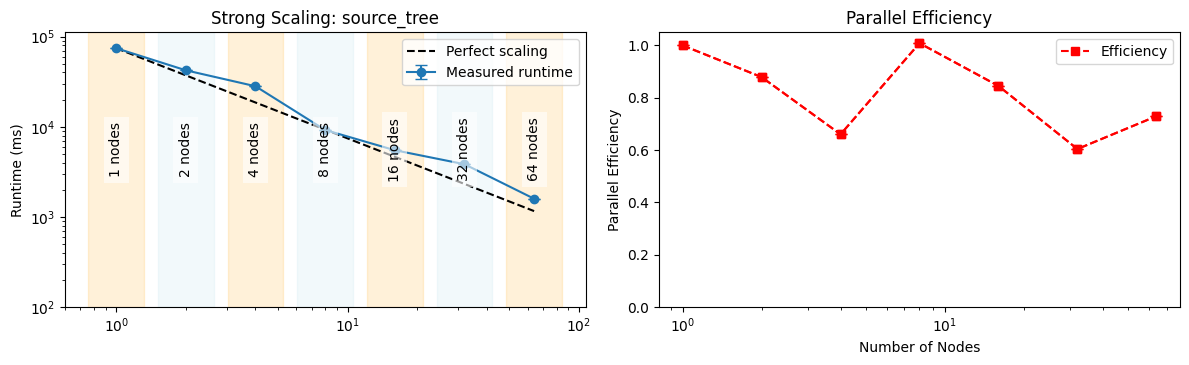

In [43]:
n_nodes = np.array([1,   2,   4,   8,  16,  32,  64])
runtime_vs_nodes(df, n_nodes, 'source_tree')

In [47]:
points_per_node

array([1.536e+08, 7.680e+07, 3.840e+07, 1.920e+07, 9.600e+06, 4.800e+06,
       2.400e+06, 1.200e+06])